# Milestone 3

## Zaawansowane modele i optymalizacja

- Modele ensemble
- Tuning hiperparametrów

## Walidacja i ocena końcowa

- Testowanie modelu na zbiorze testowym
- Użycie metryk i narzędzi do walidacji

## Interpretacja i wyjaśnienie wyników

- Feature importance
- Wykorzystanie narzędzi interpretacyjnych


In [8]:
import warnings

import sklearn.metrics

warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate

filepath = "data/creditcard_csv.csv"

df = pd.read_csv(filepath)

X = df.drop('Class', axis=1)
y = df['Class'].replace({"'0'": 0, "'1'": 1})

# dzielimy
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, amount_log=False, Vcolumns_log=False):
        self.amount_log = amount_log
        self.Vcolumns_log = Vcolumns_log

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if 'Time' in X.columns:
            X.drop('Time', axis=1, inplace=True)

        if self.amount_log and 'Amount' in X.columns:
            X['Amount'] = np.log1p(X['Amount'])

        if self.Vcolumns_log:
            V_cols = [col for col in X.columns if 'V' in col]
            X[V_cols] = X[V_cols].apply(np.abs) # wartosc bezwzgledna w celu poprawnego nalozenia logarytmu
            X[V_cols] = X[V_cols].apply(np.log1p)
        return X


## Funkcja kosztu

Funkcja odpowiedzialna za obliczenie, ile straci bank przy odpowiednich błędach modelu. Oczywiście w każdej z tych transakcji mogłaby być inna wartość, dlatego informacje zwrócone z tej funkcji potraktujemy informacyjnie.

In [10]:
# funkcja kosztu

class CustomCost:
    def __init__(self, X_with_amount):
        self.X_with_amount = X_with_amount

    def __call__(self, estimator, x, y_true):
        y_pred = estimator.predict(X)
        amount = self.X_with_amount.loc[y_true.index, 'Amount'].values

        fp_cost = 5
        tp_cost = 5
        tn_cost = 0

        total_cost = 0

        for true_label, pred_label, fn_cost in zip(y_true, y_pred, amount):
            if true_label == 0 and pred_label == 0: #TN
                total_cost += tn_cost
            elif true_label == 1 and pred_label == 0: #FN
                total_cost += fn_cost
            elif true_label == 0 and pred_label == 1: #FP
                total_cost += fp_cost
            elif true_label == 1 and pred_label == 1: #TP
                total_cost += tp_cost

        return -total_cost # ujemne bo wieksza wartosc = lepsze

## Klasyfikator głosujący

Wyświetlanie wyników wraz z róznymi miarami. Wyświetlamy dodatowo Precission i Recall. Zależy nam, aby Recall był jak najwyższy (bo bardziej opłaca się robić błędy FP niż FN). Dodatkowo użyjemy z tego powodu miarę F2-score.

In [11]:
from sklearn.metrics import make_scorer, fbeta_score

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f2': make_scorer(fbeta_score, beta=2), # f2 daje recall dwa razy ważniejszy od precision
    'roc_auc': 'roc_auc',
    'cost': CustomCost(X_with_amount=X)
}

def display_scores(scores):
    print("Wyniki recall:", scores['test_recall'])
    print("Średnia recall:", scores['test_recall'].mean())
    print("Odchylenie standardowe recall:", scores['test_recall'].std())
    print("Wyniki precision:", scores['test_precision'])
    print("Średnia precision:", scores['test_precision'].mean())
    print("Odchylenie standardowe precision:", scores['test_precision'].std())
    print("Wyniki f2:", scores['test_f2'])
    print("Średnia f2:", scores['test_f2'].mean())
    print("Odchylenie standardowe f2:", scores['test_f2'].std())
    print("Wyniki auc_roc:", scores['test_roc_auc'])
    print("Średnia auc_roc:", scores['test_roc_auc'].mean())
    print("Odchylenie standardowe auc_roc:", scores['test_roc_auc'].std())
    print("Wyniki fraud_cost:", scores['test_cost'])
    print("Średnia fraud_cost:", scores['test_cost'].mean())
    print("Odchylenie standardowe fraud_cost:", scores['test_cost'].std())

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

voting_clf = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000)),
                ('rf', RandomForestClassifier()),
                ('svc', SVC(kernel='poly', probability=True))],
    voting='soft'
)

cv_voting_clf = cross_validate(voting_clf, X_train_valid, y_train_valid, cv=5, scoring=scoring, n_jobs=-1)

display_scores(cv_voting_clf)

Bardzo niskie F2 wraz z Recall, reszta prezentuje się nienajgorzej. Nie będzie to kierunek w którym będziemy iść.

## Agregacja

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier


bag_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('Selectkbest', SelectKBest(score_func=f_classif, k=7)),
    ('bagging_clf', BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=100,
    bootstrap=True, n_jobs=-1),
     )
])

cv_bag_clf = cross_validate(bag_clf, X_train_valid, y_train_valid, scoring=scoring, cv=5)

display_scores(cv_bag_clf)

baggin_classifier gdzie k=7, n_estimators=100: \
recall: 0.77 \
precission: 0.91 \
f2: 0.79 \
auc_roc: 0.927 \
cost: -11053,98

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

bag_svm_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('Selectkbest', SelectKBest(score_func=f_classif, k=10)),
    ('bagging_clf', BaggingClassifier(
    SVC(kernel='poly'), n_estimators=10,
    bootstrap=True, n_jobs=-1),
     )
])

cv_bag_svm_clf = cross_validate(bag_svm_clf, X_train_valid, y_train_valid, scoring=scoring, cv=5)

display_scores(cv_bag_svm_clf)

baggin_classifier gdzie k=10, n_estimators = 10: \
recall: 0.70 \
precission: 0.88 \
f2: 0.73 \
auc_roc: 0.89 \
cost: -11016,98

Gorsze niż poprzednie

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('xgb_clf', GradientBoostingClassifier())
])

cv_xgb_clf = cross_validate(xgb_clf, X_train_valid, y_train_valid, scoring=scoring, cv=5, n_jobs=-1)

display_scores(cv_xgb_clf)

gradientboostingclassifier; k=10: \
recall: 0.53 \
precission: 0.78 \
f2: 0.56 \
auc_roc: 0.70 \
cost: -10943,98

Bardzo słabe, przejdźmy do lasów losowych oraz extra-trees

## Losowe lasy oraz zespół Extra-Trees

Nowa funkcja do printowania wyników:

In [ ]:
def print_scores(scores):
    for f2, recall, precision, auc_roc, cost, params in zip(scores['mean_test_f2'], scores['mean_test_recall'],
                                                  scores['mean_test_precision'], scores['mean_test_roc_auc'],
                                                  scores['mean_test_cost'], scores['params']):
        print(params,
            '\nf2: ', f2,
            'recall: ', recall,
            'cost: ', cost,
            'auc_roc: ', auc_roc,
            'precision: ', precision, '\n')

### Losowe lasy

#### Randomized Search

Na początku robimy przeszukiwanie losowe w celu obrania jakiegoś kierunku

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42)),
])

param_grid = {
    'SelectKBest__k': [5,8,10,13,15],
    'Classifier__n_estimators': [50,100,200,300,400,500],
    'Classifier__max_depth': [5,10,15,20],
    'Classifier__min_samples_split': [2,3,4],
    'Classifier__min_samples_leaf': [1,2,3,4],
    'Classifier__bootstrap': [True,False]
}

rnd_random_search = RandomizedSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True, n_iter=20)

rnd_random_search.fit(X_train_valid, y_train_valid)

In [ ]:
print_scores(rnd_random_search.cv_results_)

In [ ]:
pd.DataFrame(rnd_random_search.cv_results_).to_excel('grid_search_results/random_search.xlsx', index=False)

##### Odczyt wyników
Liczba używanych features nie koniecznie oznaczała lepsze wyniki. Jednak małe wartości tj. 5 oraz 8 nie działają zbyt dobrze.

 Zbyt głebokie drzewa/lasy zmniejszają precyzję modelu.

 Większa wartość hiperparametru "min_samples_split" pozytywnie wpływa na pełność (recall).

  Wartości kosztu są bardzo podobne dla wszystkich modeli.
  
   Wartość bootstrap ustawiona na True negatywnie wpływa na jakość modelu.

#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42)),
])

param_grid = [
    {'SelectKBest__k': [6,8,10]},
    {'Classifier__n_estimators': [50,100,200], 'Classifier__max_depth': [5,10]},
    {'Classifier__criterion': ['gini', 'entropy']},
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

In [ ]:
print_scores(rnd_grid_search.cv_results_)

In [ ]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_1.xlsx', index=False)

In [ ]:
param_grid = [
    {'SelectKBest__k': [10, 12, 14, 16],
     'Classifier__n_estimators': [200, 300, 400],
     'Classifier__max_depth': [8,10,12],
     'Classifier__criterion': ['entropy']},
    {'Classifier__min_samples_split': [2,3,4,5,6],
     'Classifier__criterion': ['entropy'],
     'SelectKBest__k': [10]},
    {'Classifier__min_samples_leaf': [1,2,3,4],
     'Classifier__criterion': ['entropy'],
     'SelectKBest__k': [10]}
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

In [ ]:
print_scores(rnd_grid_search.cv_results_)

In [ ]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_2.xlsx', index=False)

In [ ]:
param_grid = [
    {'SelectKBest__k': [9, 10, 11],
     'Classifier__n_estimators': [300],
     'Classifier__max_depth': [12,14,15]},
    {'Classifier__n_estimators': [350, 400, 500]},
]

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, criterion='entropy')), # na pewno entropia jako kryterium
])

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

In [ ]:
print_scores(rnd_grid_search.cv_results_)

In [ ]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_3.xlsx', index=False)

In [ ]:
param_grid = [
    {'Classifier__max_depth': [12,13,14],
    'Classifier__n_estimators': [275,300,325,350]}
]

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, criterion='entropy')), # na pewno entropia jako kryterium
])

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

In [ ]:
print_scores(rnd_grid_search.cv_results_)

In [ ]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_4.xlsx', index=False)

In [ ]:
rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=275, max_depth=14, criterion='entropy')),
])

param_grid = [
    {'Classifier__min_samples_leaf': [1,2],
    'Classifier__min_samples_split': [2,5,6]}
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

In [ ]:
print_scores(rnd_grid_search.cv_results_)

In [ ]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_5.xlsx', index=False)

Finalnie

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=275, max_depth=14, criterion='entropy', min_samples_split=2, min_samples_leaf=1)),
])

In [14]:
cv_rnd_clf = cross_validate(rnd_clf, X_train_valid, y_train_valid, cv=5, n_jobs=-1, scoring=scoring)

display_scores(cv_rnd_clf)

Wyniki recall: [0.85542169 0.81927711 0.77380952 0.72619048 0.80952381]
Średnia recall: 0.7968445209409065
Odchylenie standardowe recall: 0.043858579153692866
Wyniki precision: [0.92207792 0.93150685 0.92857143 0.953125   0.95774648]
Średnia precision: 0.9386055357675316
Odchylenie standardowe precision: 0.014152223962473955
Wyniki f2: [0.86797066 0.83950617 0.80049261 0.7625     0.83538084]
Średnia f2: 0.8211700558408959
Odchylenie standardowe f2: 0.036326817062199986
Wyniki auc_roc: [0.98948631 0.99029843 0.9731008  0.98064937 0.96802084]
Średnia auc_roc: 0.9803111506061825
Odchylenie standardowe auc_roc: 0.008798688997741312
Wyniki fraud_cost: [ -9490.59 -10237.81 -13995.95  -7140.62 -14404.94]
Średnia fraud_cost: -11053.982
Odchylenie standardowe fraud_cost: 2767.9894744409708


RandomForestClassifier: \
recall: 0.79 \
precission: 0.93 \
f2: 0.82 \
auc_roc: 0.98 \
cost: -11053

### Extra-Trees

#### Randomized Search

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42)),
])

param_grid = {
    'SelectKBest__k': [5,8,10,13,15],
    'Classifier__n_estimators': [50,100,200,300,400,500],
    'Classifier__max_depth': [5,10,15,20,None],
    'Classifier__min_samples_split': [2,3,4],
    'Classifier__min_samples_leaf': [1,2,3,4],
    'Classifier__bootstrap': [True,False],
    'Classifier__criterion': ['gini','entropy'],
}

ext_random_search = RandomizedSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True, n_iter=50)

ext_random_search.fit(X_train_valid, y_train_valid)

In [ ]:
pd.DataFrame(ext_random_search.cv_results_).to_excel('grid_search_results/ext_random_search.xlsx', index=False)

##### Odczyt wyników

Uczy się o wiele szybciej. Wydaje się że głębsze drzewa wydają się najlepsze. O reszcie hiperparametrów, trudno się wypowiedzieć.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42)),
])

param_grid = [
    {'SelectKBest__k': [5,10,15],
     'Classifier__n_estimators': [100,200,300],
     'Classifier__max_depth': [10,15,None],
     'Classifier__criterion': ['gini', 'entropy']},
     {'Classifier__min_samples_leaf': [1,2],
     'Classifier__min_samples_split': [2,3,4]},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

In [ ]:
print_scores(ext_grid_search.cv_results_)

In [ ]:
pd.DataFrame(ext_grid_search.cv_results_).to_excel('grid_search_results/ext_grid_search_1.xlsx', index=False)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42, max_depth=None, criterion='gini', min_samples_split=2, min_samples_leaf=1)),
])

param_grid = [
    {'SelectKBest__k': [8,10,12,14,16],
     'Classifier__n_estimators': [50,100,200,300,400,500],},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

In [ ]:
print_scores(ext_grid_search.cv_results_)

In [ ]:
pd.DataFrame(ext_grid_search.cv_results_).to_excel('grid_search_results/ext_grid_search_2.xlsx', index=False)

Wyniki są dość rozstrzelone. Dobre wyniki f2-score osiągane są dla parametrów daleko od siebie. Wybierzemy najlepsze.

criterion = 'entropy'\
max_depth = 19\
n_estimators = 250

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42, max_depth=None, criterion='gini', min_samples_split=2, min_samples_leaf=1,
                                        n_estimators=100)),
])

In [15]:
cv_ext_clf = cross_validate(ext_clf, X_train_valid, y_train_valid, cv=5, n_jobs=-1, scoring=scoring)

display_scores(cv_ext_clf)

Wyniki recall: [0.85542169 0.81927711 0.76190476 0.71428571 0.82142857]
Średnia recall: 0.7944635685599541
Odchylenie standardowe recall: 0.050094469795593316
Wyniki precision: [0.95945946 0.94444444 0.91428571 0.96774194 0.94520548]
Średnia precision: 0.9462274066251087
Odchylenie standardowe precision: 0.018234347660471977
Wyniki f2: [0.87438424 0.84158416 0.78817734 0.75376884 0.84352078]
Średnia f2: 0.8202870722775429
Odchylenie standardowe f2: 0.04330261865692104
Wyniki auc_roc: [0.97478938 0.95647119 0.92674494 0.94499654 0.95101814]
Średnia auc_roc: 0.9508040362005075
Odchylenie standardowe auc_roc: 0.01562066785531258
Wyniki fraud_cost: [ -9490.59 -10237.81 -13990.95  -7135.62 -14409.94]
Średnia fraud_cost: -11052.982
Odchylenie standardowe fraud_cost: 2769.553110993902


ExtraTreesClassifier dla najlepszych parametrów: \
recall: 0.79 \
precission: 0.94 \
f2: 0.82 \
auc_roc: 0.95 \
cost: -11052.98

### Porównanie modeli

In [ ]:
display_scores(cv_ext_clf)

In [ ]:
display_scores(cv_rnd_clf)

RandomForest ma delikatnie lepsze wyniki, ale są one mocno zbliżone do wyników dawanych przez Extra Trees, mimo bardzo dużych różnicach w czasie nauki modeli na korzyść ExtraTrees.

### Feature importance

In [16]:
def print_feature_importances(clf):
    selectkbest = clf.named_steps['SelectKBest']
    selected_features_mask = selectkbest.get_support()

    rf_model = clf.named_steps['Classifier']
    feature_importances = rf_model.feature_importances_

    original_feature_importances = np.zeros(X_train_valid.shape[1]-1)
    original_feature_importances[selected_features_mask] = feature_importances

    for importance, feature in sorted(zip(original_feature_importances, X_train_valid.columns, ), reverse=True):
        if importance > 0:
            print(f"{feature}: {importance}")

In [17]:
clf = rnd_clf

clf.fit(X_train_valid, y_train_valid)

Pipeline(steps=[('CustomTransformer', CustomTransformer()),
                ('SelectKBest', SelectKBest()),
                ('Classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=14,
                                        n_estimators=275, n_jobs=-1,
                                        random_state=42))])

In [18]:
print_feature_importances(clf)

V16: 0.24813516934736302
V13: 0.23473923948040545
V9: 0.12679898386332325
V11: 0.1262488450517961
V10: 0.06731866486944989
V3: 0.05758845302869832
V15: 0.04628292962579698
V6: 0.04265098601872183
V2: 0.028712945593879595
V17: 0.021523783120565607


In [19]:
clf = ext_clf

clf.fit(X_train_valid, y_train_valid)

Pipeline(steps=[('CustomTransformer', CustomTransformer()),
                ('SelectKBest', SelectKBest()),
                ('Classifier',
                 ExtraTreesClassifier(n_jobs=-1, random_state=42))])

In [20]:
print_feature_importances(clf)

V16: 0.1787053367857951
V13: 0.16627298801571558
V11: 0.15434571921621423
V9: 0.10400111260327595
V15: 0.08555446427871775
V10: 0.08002284631079425
V3: 0.06790183196558551
V17: 0.05893224310666333
V2: 0.055897026592978995
V6: 0.04836643112425932


Kolumny w obu lekko się różnią, jednak te najważniejsze są podobne

## Testowanie na zbiorze testowym

### Losowy las

In [62]:
from sklearn.metrics import roc_auc_score, recall_score

rnd_clf.fit(X_train_valid, y_train_valid)

y_pred = rnd_clf.predict(X_test)

print("f2: ", fbeta_score(y_test, y_pred, beta=2))
print("roc_auc: ", roc_auc_score(y_test, rnd_clf.predict_proba(X_test)[:, 1]))
print("Recall: ", recall_score(y_test, y_pred))
print("Koszt: ", -CustomCost(X_with_amount=X)(rnd_clf,X_test,y_test))

f2:  0.8123249299719888
roc_auc:  0.9662027495982195
Recall:  0.7837837837837838
Koszt:  7838.659999999998


In [45]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[42645,     3],
       [   16,    58]])

In [73]:
def plot_precision_recall_curve(clf, X_test, y_true):

    y_prob = clf.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, lw=2, color='darkorange',)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

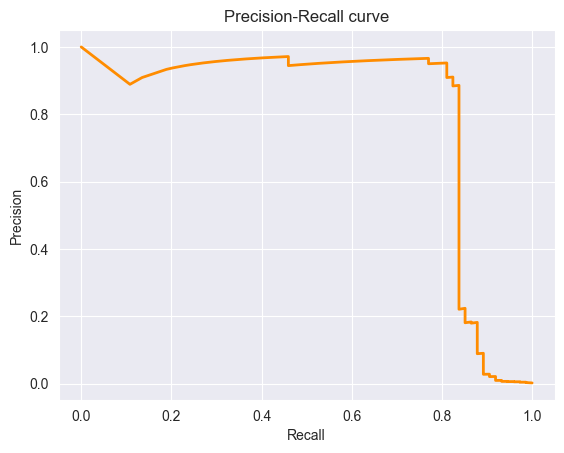

In [74]:
plot_precision_recall_curve(rnd_clf, X_test, y_test)

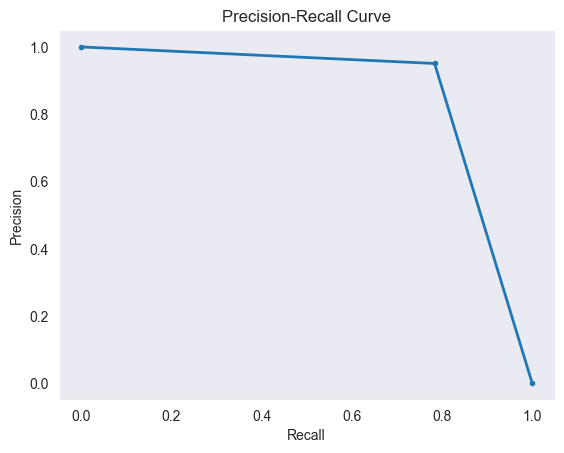

In [46]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, marker='.', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score, auc


def plot_roc(classifier,X_test, y_true, label=None):

    y_prob = classifier.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

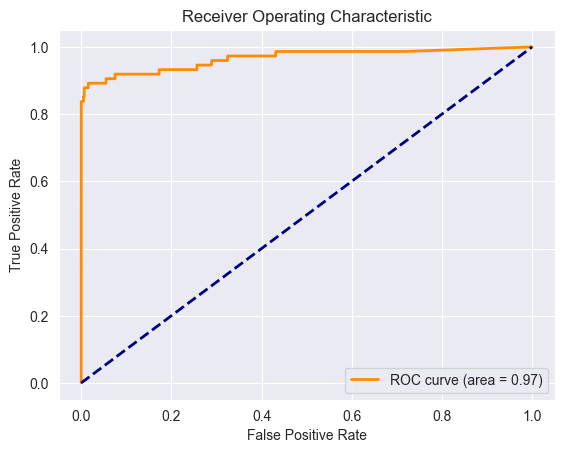

In [65]:
plot_roc(rnd_clf,X_test, y_test)

### Zespół Extra-Trees

In [63]:
from sklearn.metrics import roc_auc_score, recall_score

ext_clf.fit(X_train_valid, y_train_valid)

y_pred = ext_clf.predict(X_test)

print("f2: ", fbeta_score(y_test, y_pred, beta=2))
print("roc_auc: ", roc_auc_score(y_test, ext_clf.predict_proba(X_test)[:, 1]))
print("Recall: ", recall_score(y_test, y_pred))
print("Koszt: ", -CustomCost(X_with_amount=X)(ext_clf,X_test,y_test))

f2:  0.8100558659217877
roc_auc:  0.9376421124275656
Recall:  0.7837837837837838
Koszt:  7858.659999999998


In [51]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[42644,     4],
       [   16,    58]])

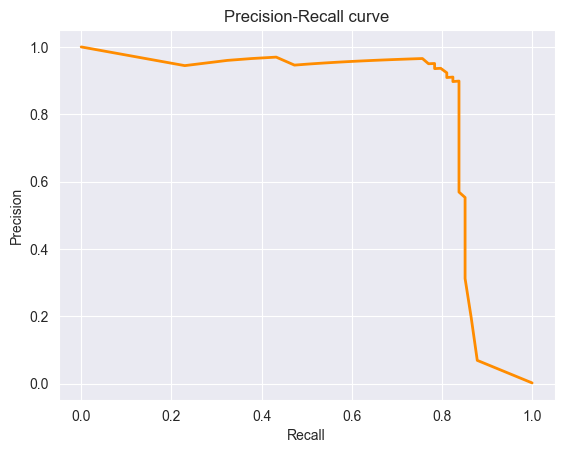

In [75]:
plot_precision_recall_curve(ext_clf, X_test, y_test)

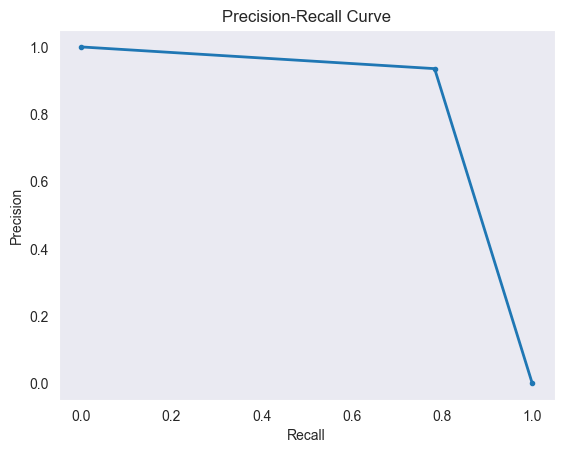

In [52]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, marker='.', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

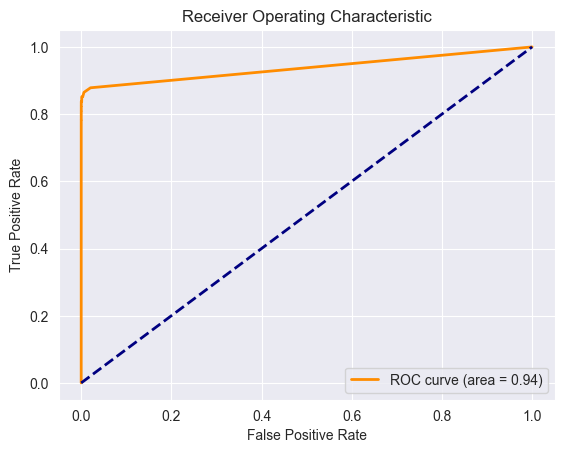

In [66]:
plot_roc(ext_clf, X_test, y_test)

RandomForest posiada o 1 mniej FP i ma o 1 więcej poprawnie zaklasyfikowanych rekordów. Jednak różnica ta jest niewielka, a błąd jaki został poopełniony przez ExtraTrees jest FP, czyli model zaklasyfikował jako oszustwo transakcję poprawną. Jest to mniej krzywdzący dla banku błąd. Modele te działają podobnie, ExtraTrees liczą się odczuwalnie szybciej.

## Wykorzystanie narzędzi interpretacyjnych do zrozumienia decyzji modelu

In [54]:
import lime.lime_tabular
import matplotlib.pyplot as plt
import random as rnd

def explain_lime(estimator, index=None):

    if index is None:
        index = rnd.randint(0, len(X_test)-1)
    y_pred = estimator.predict(X_test)

    # Transformacja X_train_valid
    X_train_valid_transformed = estimator.named_steps['SelectKBest'].transform(
        estimator.named_steps['CustomTransformer'].transform(X_train_valid)
    )

    # feature names
    selected_feature_indices = estimator.named_steps['SelectKBest'].get_support(indices=True)
    selected_feature_names = X_train_valid.columns[1:].values[selected_feature_indices]

    # Init expleinera
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_valid_transformed,
        feature_names=selected_feature_names,
        discretize_continuous=True,
        mode='classification'
    )

    # wybranie instancji
    instance = X_test.iloc[[index]]

    # Transformacja instancji
    instance_transformed = estimator.named_steps['SelectKBest'].transform(
        estimator.named_steps['CustomTransformer'].transform(instance)
    )

    # Wytlumaczenie
    exp = explainer.explain_instance(
        data_row=instance_transformed[0],  # must be a 1D array
        predict_fn=estimator.named_steps['Classifier'].predict_proba,
        num_features=10
    )

    # Wizualizacja
    true_label = y_test.iloc[index]
    pred_label = y_pred[index]
    fig = exp.as_pyplot_figure()
    fig.suptitle(f'Index: {index} True label: {true_label} Predicted label: {pred_label}')
    plt.show()

In [55]:
y_pred = ext_clf.predict(X_test)

tp_indices = []  # True Positives
tn_indices = []  # True Negatives
fp_indices = []  # False Positives
fn_indices = []  # False Negatives

# Iterate through the predictions and true labels
for idx, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
    if true_label == 1 and pred_label == 1:  # True Positive
        tp_indices.append(idx)
    elif true_label == 0 and pred_label == 0:  # True Negative
        tn_indices.append(idx)
    elif true_label == 0 and pred_label == 1:  # False Positive
        fp_indices.append(idx)
    elif true_label == 1 and pred_label == 0:  # False Negative
        fn_indices.append(idx)

tp_examples = X_test.iloc[tp_indices] if tp_indices else None
tn_examples = X_test.iloc[tn_indices] if tn_indices else None
fp_examples = X_test.iloc[fp_indices] if fp_indices else None
fn_examples = X_test.iloc[fn_indices] if fn_indices else None

print('TP: ', tp_indices[0])
print('TN: ', tn_indices[0])
print('FP: ', fp_indices[0])
print('FN: ', fn_indices[0])

TP:  735
TN:  0
FP:  7306
FN:  1289


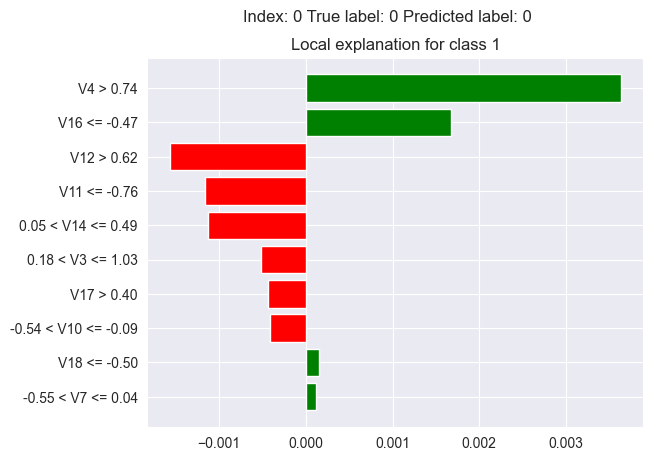

In [56]:
explain_lime(ext_clf, 0)

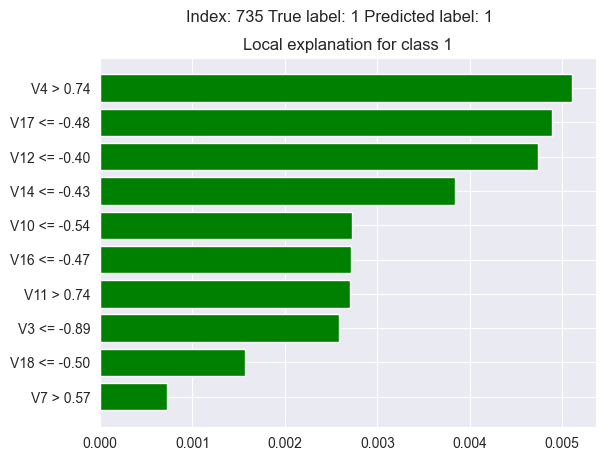

In [57]:
explain_lime(ext_clf, 735)

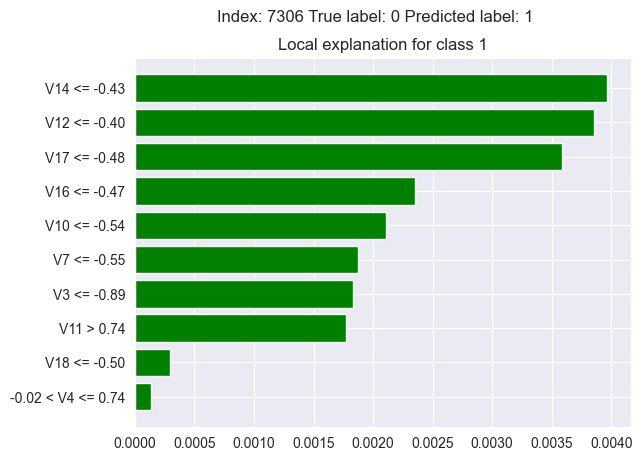

In [58]:
explain_lime(ext_clf, 7306)

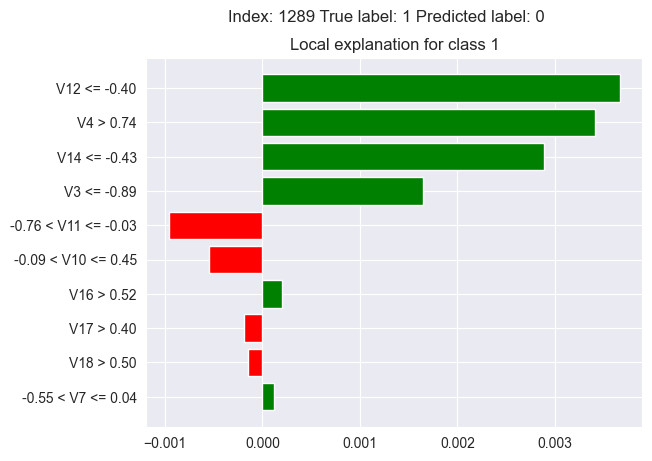

In [59]:
explain_lime(ext_clf, 1289)

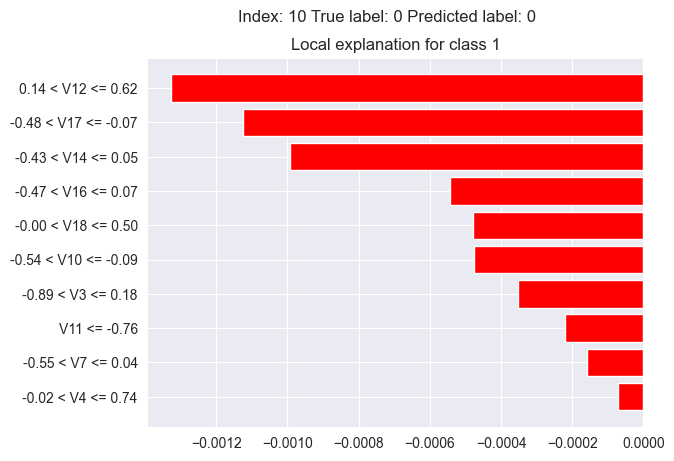

In [60]:
explain_lime(ext_clf, 10)

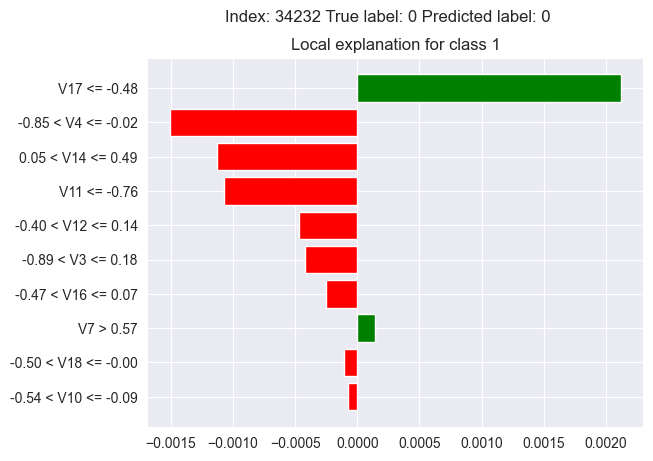

In [61]:
explain_lime(ext_clf)